In [1]:
import pandas as pd
import json
import jsonlines
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
x = torch.arange(3)[None, None]
h = torch.arange(3)[None, None].flip(-1)
y = F.conv1d(x, h)
print(x, y, h)


tensor([[[0, 1, 2]]]) tensor([[[1]]]) tensor([[[2, 1, 0]]])


In [14]:
qkv_savanna = torch.load(f"/home/zymrael/checkpoints/evo2/activations/savanna/pre_flashattn_8.pt").squeeze().detach().float().cpu()
qkv_vortex = torch.load(f"/home/zymrael/checkpoints/evo2/activations/vortex/pre_flashattn_8.pt").squeeze().detach().float().cpu()

print(qkv_savanna.shape)
print(qkv_vortex.shape)

diff = (qkv_savanna - qkv_vortex).abs().detach().float().cpu().numpy()
print(diff.max())
print(diff.min())
print(diff.mean())
print(qkv_vortex.shape, qkv_savanna.shape)


torch.Size([4, 3, 32, 128])
torch.Size([4, 3, 32, 128])
14.8125
0.0
0.5234044
torch.Size([4, 3, 32, 128]) torch.Size([4, 3, 32, 128])


/tmp/ipykernel_929320/4278542052.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qkv_savanna = torch.load(f"/home/zymrael/checkpoints/evo2/activations/savanna/pre_flasha

In [24]:
qkv_vortex_2 = qkv_vortex.reshape(4, -1)
qkv_vortex_2 = qkv_vortex_2.reshape(
    4,
    32,
    3,
    128
)
q,k,v = qkv_vortex_2.unbind(-2)
qkv_vortex_2 = torch.cat([
    q.reshape(4, -1),
    k.reshape(4, -1),
    v.reshape(4, -1)
], dim=-1)
qkv_vortex_2 = qkv_vortex_2.reshape(4, 3, 32, 128)


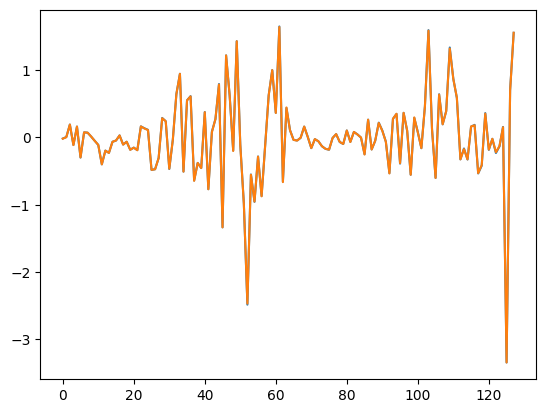

In [28]:
plt.plot(qkv_vortex_2[0,0,-1])
plt.plot(qkv_savanna[0,0,-1])
plt.show()


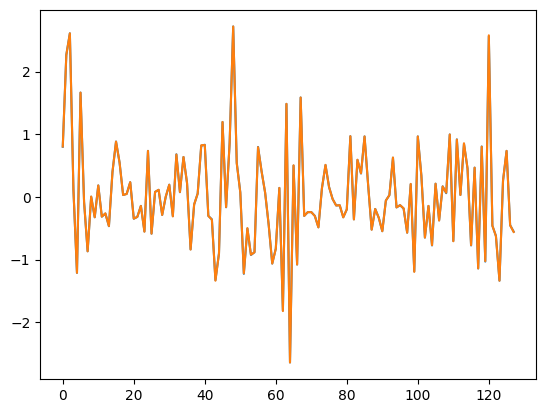

In [15]:
plt.plot(qkv_vortex[0,0,0])
plt.plot(qkv_savanna[0,0,0])
plt.show()


In [15]:
z = torch.load(f"/home/zymrael/checkpoints/evo2/activations/vortex/pre_filter_1.pt")
z_savanna = torch.load(f"/home/zymrael/checkpoints/evo2/activations/savanna/pre_filter_1.pt")
error = (z - z_savanna.squeeze()).abs().detach().float().cpu().numpy()
z = z.squeeze().detach().float().cpu().numpy()
z_savanna = z_savanna.squeeze().detach().float().cpu().numpy()
print(error)
print(error.max())
print(error.min())
print(error.mean())


[[[0.0000000e+00 9.7656250e-03 0.0000000e+00 ... 3.1250000e-02
   7.6293945e-06 6.2500000e-02]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 3.1250000e-02 3.1250000e-02 ... 6.2500000e-02
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 1.5625000e-02 0.0000000e+00 ... 1.5625000e-02
   1.9073486e-06 0.0000000e+00]]]
1.0
0.0
0.013634346


/tmp/ipykernel_642449/1860071299.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load(f"/home/zymrael/checkpoints/evo2/activations/vortex/pre_filter_1.pt")
/tm

In [19]:
z.shape

(4, 12288)

In [22]:
z.max()

165.0

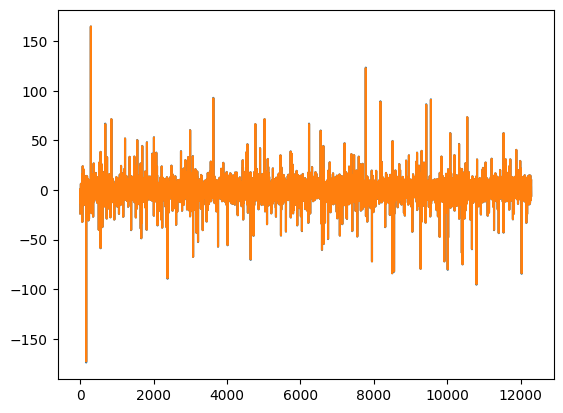

In [24]:
#plt.plot(error[0,0])
plt.plot(z[0])
plt.plot(z_savanna[0])
#plt.show()

In [3]:
bwd_test_log = "logs/parsed_test_bwd.log"
fwd_test_log = "logs/parsed_test_fwd.log"

In [4]:
raw_bwd_logs = [json.loads(line.strip()) for line in open(bwd_test_log).readlines()]

In [5]:
df = pd.DataFrame(raw_bwd_logs).drop("is_interpreter", axis=1)

In [60]:
group_keys = [k for k in df.columns if not ("DEBUG" in k)]
run_config_keys = [k for k in group_keys if not any(x in k for x in ["passed", "diff"])]
bwd_key_pats = ["dx", "dB", "dC", "dh"]
fwd_key_pat = ["return_", "y2_", "y_", "T_", "T_hat"]
common_keys = [k for k in run_config_keys if not any(x in k for x in bwd_key_pats + fwd_key_pat)]
bwd_group_keys = [k for k in group_keys if not any(x in k for x in fwd_key_pat)]
fwd_group_keys = [k for k in group_keys if not any(x in k for x in bwd_key_pats)] 

In [61]:
#Bwd tests sliced by TMA
bwd_tests = df[bwd_group_keys]
bwd_tests_TMA = bwd_tests[bwd_tests.USE_TMA]
bwd_tests_NO_TMA = bwd_tests[~bwd_tests.USE_TMA]

In [63]:
# These are fwd pass in e2e fwd / bwd tests
fwd_tests = df[df.y_diff.notna()][fwd_group_keys]
fwd_tests_TMA = fwd_tests[fwd_tests.USE_TMA]
fwd_tests_NO_TMA = fwd_tests[~fwd_tests.USE_TMA]

In [70]:
# Forward failures
y_failures = fwd_tests[fwd_tests.y_passed == False].sort_values("y_diff", ascending=False)[common_keys + ["y_diff"]]

# Backward failures
dx_failures = bwd_tests[bwd_tests.dx_passed == False].sort_values("dx_diff", ascending=False)[common_keys + ["dx_diff"]]
dB_failures = bwd_tests[bwd_tests.dB_passed == False].sort_values("dB_diff", ascending=False)[common_keys + ["dB_diff"]]
dC_failures = bwd_tests[bwd_tests.dC_passed == False].sort_values("dC_diff", ascending=False)[common_keys + ["dC_diff"]]
dh_failures = bwd_tests[bwd_tests.dh_passed == False].sort_values("dh_diff", ascending=False)[common_keys + ["dh_diff"]]

In [75]:
assert sum(y_failures.dtype == "float32") == 0
assert sum(dx_failures.dtype == "float32") == 0
assert sum(dB_failures.dtype == "float32") == 0
assert sum(dC_failures.dtype == "float32") == 0
assert sum(dh_failures.dtype == "float32") == 0